## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, glob, re, string

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_string, strip_short, remove_stopwords, strip_numeric, strip_punctuation, STOPWORDS
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.matutils import corpus2csc

import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
translator = str.maketrans('', '', string.punctuation)

from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
sb = nltk.SnowballStemmer("english")
ps = nltk.PorterStemmer()

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings('ignore')

C:\Users\mdecaro\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load notes

In [2]:
# Adjust path/column names as needed
cohort_notes = pd.read_excel("cohort_1_notes.xlsx")
cohort_notes.columns = ['PATID', 'RX_START_DATE', 'DOCUMENT_TYPE', 'NOTE_DATE', 'PlainText']

## Clean the notes (Remove stop words, apply lemmatizer)

In [4]:
def clean_text(txt):
    txt = "".join([c for c in txt if c not in string.punctuation])
    tokens = re.split('\W+', txt)
    #txt = " ".join([sb.stem(word) for word in tokens if word not in stopwords])
    txt = " ".join([lemmatizer.lemmatize(word) for word in tokens if word not in stopwords])
    return txt

# Add a new column for the cleaned text
cohort_notes = cohort_notes.dropna(subset=['PlainText'])
cohort_notes['CleanText'] = cohort_notes['PlainText'].apply(lambda x: clean_text(x))

## Convert words to IDs and create the LDA model corpus

In [6]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return final

In [7]:
data_words = gen_words(cohort_notes['CleanText'])

# First 10 words from the first note
data_words[0][:10]

['documentation',
 'location',
 'tirr',
 'memorial',
 'hermann',
 'brain',
 'injury',
 'rehabilitation',
 'admission',
 'history']

In [8]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

## Run the LDA Model

In [53]:
num_topics = [10, 25, 50, 100]
num_unique_topics = []
cv = []
umass = []
perplexity = []


for topics in num_topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                #alpha="auto"
                                                alpha="asymmetric")


    # Print the top contributing topics
    #print(lda_model.print_topics())

    # Compute Coherence Score (c_v)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    cv.append(coherence_model_lda.get_coherence())
    #print('\nCoherence Score: ', coherence_cv)

    # Compute Coherence Score (UMass)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence="u_mass")
    umass.append(coherence_model_lda.get_coherence())
    #print('\nCoherence Score: ', coherence_umass)

    # Compute the model perplexity
    perplexity.append(lda_model.log_perplexity(corpus))
    #print('\nPerplexity: ', perplexity)
    
    # Get the number of unique topics
    lst = lda_model.show_topics(num_topics=topics, formatted=False, num_words= 20)
    topics_df = pd.DataFrame(np.empty((0,2)))
    topics_df.columns = ["topic_id", "words"]

    for index, topic in enumerate(lst):    
        words = []
        for word in topic[1]:
            words.append(word[0])

        df2 = {"topic_id":topic[0], "words":", ".join(words)}
        df2 = pd.DataFrame(df2, index=[0])
        topics_df = pd.concat([topics_df, df2], ignore_index=True)
        
    num_unique_topics.append(len(topics_df["words"].drop_duplicates().reset_index().drop(columns="index")))

In [59]:
# Print the topics
lda_model.show_topics(num_topics=100, formatted=False, num_words= 20)

## Unique Topics

In [28]:
pd.set_option('display.max_colwidth', None)

In [54]:
topics_df

,topic_id,words
0,0.0,"cease, revisons, saccharomyces, panels, peristomal, citrated, dmv, boulardii, marcy, letty, cordovamarcelia, pmmurphy, digitalreport, tomorrowdr, pillia, generalizwed, fucabg, forever, reducible, ptotskilled"
1,1.0,"west, south, loop, suite, msb, gangrene, revatio, fucabg, cease, boulardii, marcy, letty, cordovamarcelia, pmmurphy, digitalreport, tomorrowdr, pillia, gastritisulcers, reducible, saccharomyces"
2,2.0,"call, dr, concern, sent, question, time, see, md, body, first, would, re, pm, stated, thank, work, dear, know, prescription, understand"
3,3.0,"range, egfr, reference, level, the, lvl, total, used, patient, extreme, population, ckdepi, qlh, formula, individual, mass, validated, meql, value, program"
4,4.0,"cease, revisons, saccharomyces, panels, peristomal, citrated, dmv, boulardii, marcy, letty, cordovamarcelia, pmmurphy, digitalreport, tomorrowdr, pillia, generalizwed, fucabg, forever, reducible, ptotskilled"
...,...,...
95,95.0,"cease, revisons, saccharomyces, panels, peristomal, citrated, dmv, boulardii, marcy, letty, cordovamarcelia, pmmurphy, digitalreport, tomorrowdr, pillia, generalizwed, fucabg, forever, reducible, ptotskilled"
96,96.0,"pediatric, clinical, therefore, database, laboratories, represent, internally, context, siemens, thorough, analyzer, biochemistry, caliper, clsibased, transference, vista, practice, hgb, lcsw, hct"
97,97.0,"yes, by, procedure, site, no, last, case, surgical, md, time, skin, antibiotic, position, needle, saline, or, check, source, applied, score"
98,98.0,"cease, revisons, saccharomyces, panels, peristomal, citrated, dmv, boulardii, marcy, letty, cordovamarcelia, pmmurphy, digitalreport, tomorrowdr, pillia, generalizwed, fucabg, forever, reducible, ptotskilled"


In [55]:
len(topics_df["words"].drop_duplicates().reset_index().drop(columns="index"))

80

## Figure: Unique vs Trained Topics

Text(1.0, 1.0, 'LDA Model Unique vs Trained Topics')

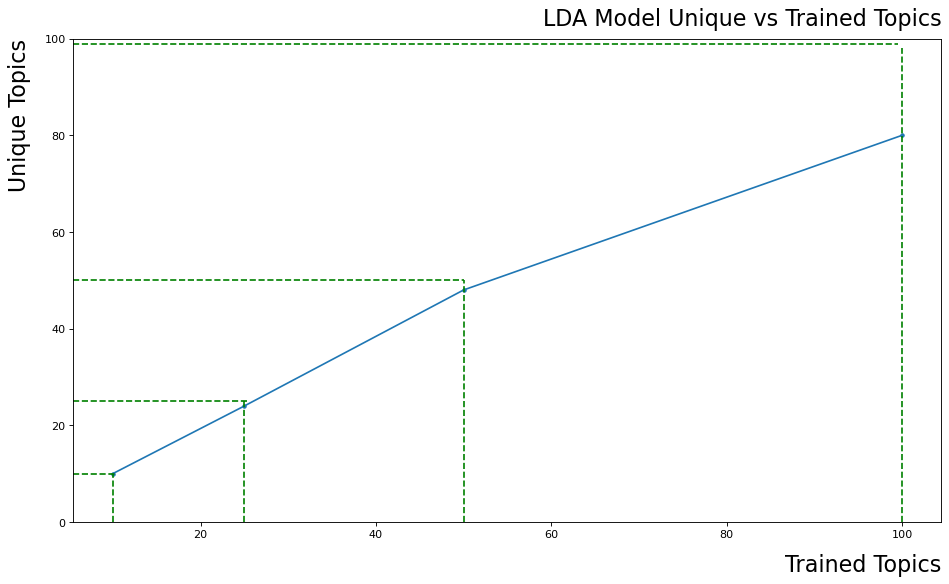

In [56]:
from matplotlib.pyplot import figure
figure(figsize=(14, 8), dpi = 80)  # This must come before labels.

x = num_topics 
y = num_unique_topics

ax = plt.plot(x, y, '.-')
plt.ylim([0, num_topics[-1]])

plt.axvline(x = 10, color = 'g', linestyle='--', ymax=0.1)
plt.axvline(x = 25, color = 'g', linestyle='--', ymax=0.25)
plt.axvline(x = 50, color = 'g', linestyle='--', ymax=0.5)
plt.axvline(x = 100, color = 'g', linestyle='--', ymax=0.98)

plt.axhline(y = 10, color = 'g', linestyle = '--', xmax=0.05)
plt.axhline(y = 25, color = 'g', linestyle = '--', xmax=0.2)
plt.axhline(y = 50, color = 'g', linestyle = '--', xmax=0.45)
plt.axhline(y = 99, color = 'g', linestyle = '--', xmax=0.95)

plt.xlabel('Trained Topics', fontsize = 20, loc = 'right', labelpad = 12)  # Size of labels and title can be adjusted.
plt.ylabel('Unique Topics', fontsize = 20, loc = 'top', labelpad = 12)    # Title position can be adjusted.
plt.title('LDA Model Unique vs Trained Topics', fontsize = 20, loc = 'right', pad = 12)  # Pad and labelpad set distance between tick and axes labels.

Text(1.0, 1.0, 'LDA Model Coherence vs Trained Topics')

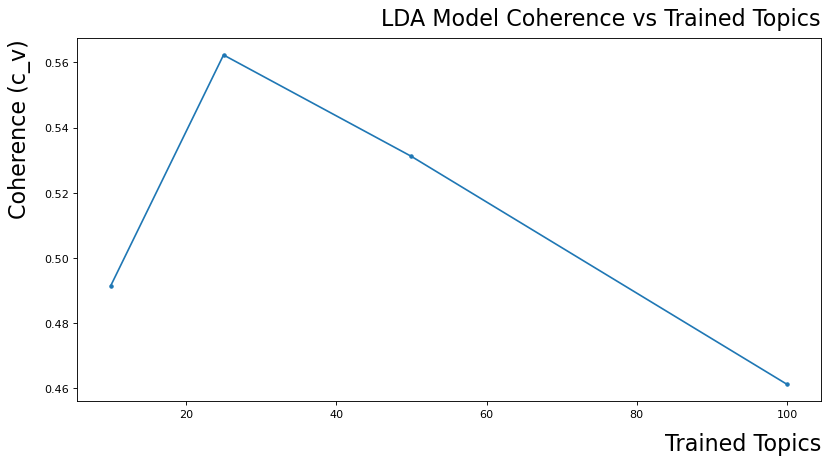

In [57]:
figure(figsize=(12, 6), dpi = 80)

x = num_topics
y = cv

ax = plt.plot(num_topics, cv, '.-')

plt.xlabel('Trained Topics', fontsize = 20, loc = 'right', labelpad = 12)  # Size of labels and title can be adjusted.
plt.ylabel('Coherence (c_v)', fontsize = 20, loc = 'top', labelpad = 12)    # Title position can be adjusted.
plt.title('LDA Model Coherence vs Trained Topics', fontsize = 20, loc = 'right', pad = 12)  # Pad and labelpad set distance between tick and axes labels.

Text(1.0, 1.0, 'LDA Model Perplexity vs Trained Topics')

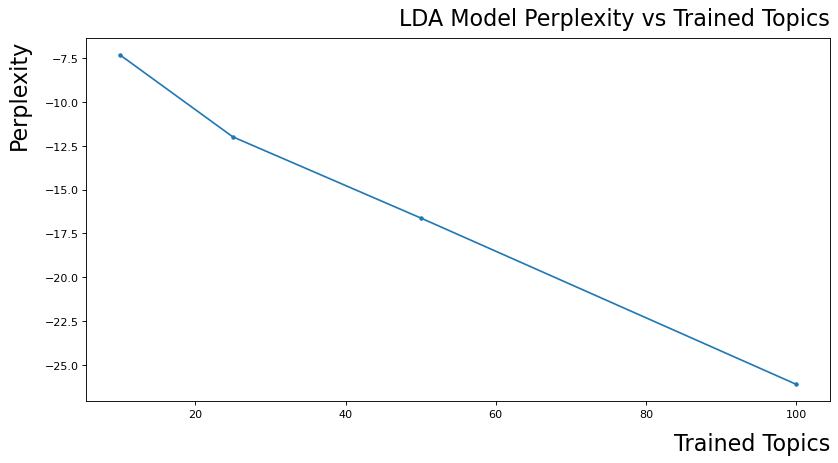

In [58]:
figure(figsize=(12, 6), dpi = 80)

x = num_topics
y = perplexity

ax = plt.plot(num_topics, perplexity, '.-')

plt.xlabel('Trained Topics', fontsize = 20, loc = 'right', labelpad = 12)  # Size of labels and title can be adjusted.
plt.ylabel('Perplexity', fontsize = 20, loc = 'top', labelpad = 12)    # Title position can be adjusted.
plt.title('LDA Model Perplexity vs Trained Topics', fontsize = 20, loc = 'right', pad = 12)  # Pad and labelpad set distance between tick and axes labels.

## Optional: Save / Load the model

In [22]:
from gensim.test.utils import datapath

save_model = False
load_model = False

# Set the model path
path = r"C:\Users\mdecaro\gitlab\HDPA\lda_model"

if save_model:
    temp_file = datapath(path)
    lda_model.save(temp_file)
    
if load_model:
    temp_file = datapath(path)
    lda_model = LdaModel.load(temp_file)